## **SKN08-2ND-PROJECT OJ**

### **[Project Title: Netflix Movies and TV shows clustering]**
---

* Project type - Clustering, content based recommender system
* data reference - Amaa Vora https://www.keggle.com/amaavora
* paper reference - 'https://www.researchgate.net/publication/359747031_Data_Analysis_on_Netflix_datasets'

* index: 
    1. Problem statement
    2. Importing the libraries and the dataset
    3. Understanding data
    4. Cleaning data
    5. Exploratory data analysis
    6. Data preprocessing
    7. Clusters implementation
    8. Building content based recommender system
    9. Conclusions
    10. References

### **1. Probelm statement:**
---

* The goal of this project is to classify/group the Neflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other.

### **2. Importing the libraries and the dataset:**
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS
import re
import string
import unicodedata
import nltk

from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string 
string.punctuation
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
sns.set()

In [440]:
# reading data
path = '../data/Netflix_data.csv'

original_df = pd.read_csv(path, index_col='show_id')
df = original_df.copy()

### **3. Understanding data:**
---

In [441]:
# top 5 rows
df.head()

type  ...                                        description
show_id           ...                                                   
s1       TV Show  ...  In a future where the elite inhabit an island ...
s2         Movie  ...  After a devastating earthquake hits Mexico Cit...
s3         Movie  ...  When an army recruit is found dead, his fellow...
s4         Movie  ...  In a postapocalyptic world, rag-doll robots hi...
s5         Movie  ...  A brilliant group of students become card-coun...

[5 rows x 11 columns]

In [442]:
# dataframe shape
df.shape

(7789, 11)

The dataset contains 7787 records and 11 attributes.

In [443]:
# unique values in each column
df.nunique()

type               2
title           7788
director        4049
cast            6831
country          681
date_added      1512
release_year      73
rating            14
duration         216
listed_in        492
description     7770
dtype: int64

#### **3.1 Attribute Information:**

1. show_id: Unique ID for every Movie / TV Show
2. type: Identifier - A Movie or TV Show
3. title: Title of the Movie / TV Show
4. director: Director of the Movie
5. cast: Actors involved in the movie / show
6. country: Country where the movie / show was produced
7. data_added: Date it was added on Netflix
8. release_year: Actual Releaseyear of the movie / show
9. rating: TV Rating of the movie / show
10. duration: Total Duration - in minutes or number of seasons
11. listed_in: Genre
12. description: The Summary description

#### **4. Cleaning data:**
---

#### **4.1 Checking for duplicate records:**

In [444]:
# Checking for duplicate records
df.duplicated().value_counts()

False    7789
Name: count, dtype: int64

There are no duplicated records in the dataset.

#### **4.2. Checking for missing values and handing them:**

In [445]:
# Visualizing the missing values
# Checking Null Value by plotting Heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False)

<Axes: ylabel='show_id'>

In [446]:
# Missing values in the dataset
df.isna().sum()

type               2
title              1
director        2391
cast             720
country          509
date_added        12
release_year       2
rating             9
duration           2
listed_in          2
description        1
dtype: int64

There are many missing values in director, cast, country, data_added, and rating columns.

In [447]:
# Checking the unique values in each attribute of the dataset
df.nunique()

type               2
title           7788
director        4049
cast            6831
country          681
date_added      1512
release_year      73
rating            14
duration         216
listed_in        492
description     7770
dtype: int64

* The missing values in the director, cast, and country attributes can be replaced with 'Unknown'.
* 10 records with missing values in the date_added column can be dropped.
* The missin values in rating can be imputed with its mode, since this attribute is discrete.

In [448]:
# Handling the missing values
df[['director','cast','country']] = df[['director','cast','country']].fillna('Unknown')
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])
df.dropna(axis=0, inplace = True)

In [449]:
#visualizing the director, cast, country using boxplot
sns.boxplot(data=df.select_dtypes(include='number'))
plt.title('Boxplot of Numeric Columns After Handling Missing Values')
plt.ylabel('Values')
plt.xlabel('Columns')
plt.show()

In [450]:
df.shape

(7777, 11)

We have successfully handled all the missing values in the dataset.

#### **4.3. Country, listed_in:**

In [451]:
# Top countries
df.country.value_counts()

country
United States                                     2549
India                                              923
Unknown                                            506
United Kingdom                                     396
Japan                                              225
                                                  ... 
Peru, United States, United Kingdom                  1
Saudi Arabia, United Arab Emirates                   1
United Kingdom, France, United States, Belgium       1
France, Norway, Lebanon, Belgium                     1
Austria, Iraq, United States                         1
Name: count, Length: 682, dtype: int64

In [452]:
# Genre of shows
df.listed_in.value_counts()

listed_in
Documentaries                                                334
Stand-Up Comedy                                              321
Dramas, International Movies                                 320
Comedies, Dramas, International Movies                       243
Dramas, Independent Movies, International Movies             215
                                                            ... 
Sports Movies                                                  1
Crime TV Shows, TV Horror, TV Mysteries                        1
Children & Family Movies, Classic Movies, Dramas               1
Romantic TV Shows, Spanish-Language TV Shows, TV Comedies      1
Dramas, Faith & Spirituality, Sports Movies                    1
Name: count, Length: 491, dtype: int64

* There are some movies / TV shows that were filmed in multiple countries, have multiple genres associated with it.
* To simplify the analysis, let's consider only the primary country where that respective movie / TV show was filmed.
* Alos, let's consider only the primary genre of the respective movie / TV show.

In [453]:
# Choosing the primary country and primary genre to simplfiy the analysis.
df['country'] = df['country'].apply(lambda x: x.split(',')[0])
df['listed_in'] = df['listed_in'].apply(lambda x: x.split('.')[0])

In [454]:
# Country in which a movie was produced
df.country.value_counts()

country
United States     2877
India              956
United Kingdom     576
Unknown            506
Canada             259
                  ... 
Jamaica              1
Cyprus               1
Greece               1
Paraguay             1
Somalia              1
Name: count, Length: 82, dtype: int64

In [455]:
# genre of shows
df.listed_in.value_counts()

listed_in
Documentaries                                                334
Stand-Up Comedy                                              321
Dramas, International Movies                                 320
Comedies, Dramas, International Movies                       243
Dramas, Independent Movies, International Movies             215
                                                            ... 
Sports Movies                                                  1
Crime TV Shows, TV Horror, TV Mysteries                        1
Children & Family Movies, Classic Movies, Dramas               1
Romantic TV Shows, Spanish-Language TV Shows, TV Comedies      1
Dramas, Faith & Spirituality, Sports Movies                    1
Name: count, Length: 491, dtype: int64

#### **4.4. Typecasting 'duration' from string to integer**

In [456]:
# Splitting the duration column, and changing the datatype to integer
df['duration'] = df['duration'].apply(lambda x: int(x.split()[0]))

In [457]:
# Number of seasons for tv shows
df[df['type']=='TV Show'].duration.value_counts()

duration
1     1608
2      378
3      183
4       86
5       57
6       30
7       19
8       18
9        8
10       5
11       2
15       2
12       2
13       1
16       1
Name: count, dtype: int64

In [458]:
# Movie length in minutes
df[df['type']=='Movie'].duration.unique()

array([ 93,  78,  80, 123,  95, 119, 118, 143, 103,  89,  91, 149, 144,
       124,  87, 110, 128, 117, 100,  84,  99,  90, 102, 104, 105,  56,
       125,  81,  97, 106, 107, 109,  44,  75, 101,  37, 113, 114, 130,
        94, 140, 135,  82,  70, 121,  92, 164,  53,  83, 116,  86, 120,
        96, 126, 129,  77, 137, 148,  28, 122, 176,  85,  22,  68, 111,
        29, 142, 168,  21,  59,  20,  98, 108,  76,  26, 156,  30,  57,
       150, 133, 115, 154, 127, 146, 136,  88, 131,  24, 112,  74,  63,
        38,  25, 174,  60, 153, 158, 151, 162,  54,  51,  69,  64, 147,
        42,  79,  40,  45, 172,  10, 163,  55,  72,  61,  71, 160, 171,
        48, 139, 157,  15,  65, 134, 161,  62, 186,  49,  73,  58, 165,
       166, 138, 159, 141, 132,  52,  67,  34,  66, 312, 180,  47, 155,
        14, 177,  11,   9,  46, 145,   8,  12,  43,  50,  23, 185, 200,
       169,  27, 170, 196,  33, 181, 204,  32,  35, 167, 179, 193,  13,
       214,  17, 173, 192, 209, 187,  41, 182, 224, 233, 189, 15

In [459]:
# datatype of duration
df.duration.dtype

dtype('int64')

We have successfully converted the datatype of duration column to int.

#### **4.5 Typecasting 'data_added' from string to datatime:**

In [460]:
df['date_added'] = pd.to_datetime(df['date_added'], format="%Y-%m-%d", errors='coerce')

In [461]:
# first and last date on which a show was added on Netflix
df.date_added.min(), df.date_added.max()
print("\nMin date:", df.date_added.min())
print("\nMax date:", df.date_added.max())


Min date: 2008-01-01 00:00:00

Max date: 2021-01-16 00:00:00


In [462]:
df

type  ...                                        description
show_id           ...                                                   
s1       TV Show  ...  In a future where the elite inhabit an island ...
s2         Movie  ...  After a devastating earthquake hits Mexico Cit...
s3         Movie  ...  When an army recruit is found dead, his fellow...
s4         Movie  ...  In a postapocalyptic world, rag-doll robots hi...
s5         Movie  ...  A brilliant group of students become card-coun...
...          ...  ...                                                ...
s7783      Movie  ...  When Lebanon's Civil War deprives Zozo of his ...
s7784      Movie  ...  A scrappy but poor boy worms his way into a ty...
s7785      Movie  ...  In this documentary, South African rapper Nast...
s7786    TV Show  ...  Dessert wizard Adriano Zumbo looks for the nex...
s7787      Movie  ...  This documentary delves into the mystique behi...

[7777 rows x 11 columns]

The shows were added on Netflix between 2008-01-01 and 2021-01-16.

In [463]:
# Adding new attributes month and year of date added

df['month_added'] = df['date_added'].dt.month
df['year_added'] = df['date_added'].dt.year
df.drop('date_added', axis=1, inplace=True)

#### **4.6. Rating:**

The ratings can be changed to age restrictions that apply on certain movies and TV shows.

In [464]:
# Age ratings for shows in the dataset
plt.figure(figsize=(10,5))
sns.countplot(x='rating', data=df, palette='deep')

<Axes: xlabel='rating', ylabel='count'>

Highest number of shows on Netflix are rated by TV-MA, followed by TV-14 and TV-PG

In [337]:
# Age ratings
df.rating.unique()

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y',
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

In [338]:
# Changing the values in the rating column
rating_map = {'TV-MA': 'Adults',
              'R': 'Adults',
              'PG-13': 'Teens',
              'TV-14': 'Young Adults',
              'TV-PG': 'Older Kids',
              'NR': 'Adults',
              'TV-G': 'Kids',
              'TV-Y': 'Kids',
              'TV-Y7': 'Older Kids',
              'G': 'Kids',
              'NC-17': 'Adults',
              'TV-Y7-FV': 'Older Kids',
              'UR': 'Adults'}

df['rating'].replace(rating_map, inplace=True)
df['rating'].unique()

array(['Adults', 'Teens', 'Young Adults', 'Older Kids', 'Kids', 'PG'],
      dtype=object)

<Axes: xlabel='rating', ylabel='count'>

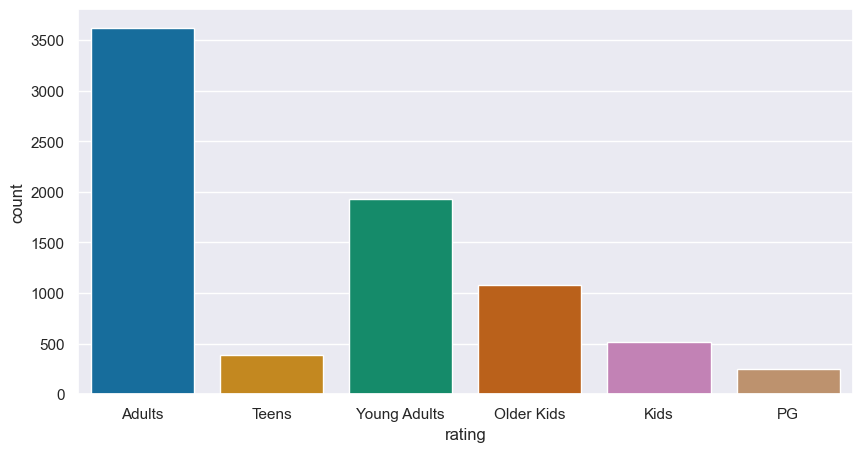

In [425]:
# Age ratings for shows in the dataset
plt.figure(figsize=(10,5))
sns.countplot(x='rating', data=df, palette='colorblind')

Around 50% shows on Netflix are produced for adult audience. Followed by young adults, older kids and kids. Netflix has the least number of shows that are specifically produced for teenages than other age groups.

### **5. Exploratory Data Analysis:**
---

#### **5.1. Univatiate Analysis:**

Text(0.5, 1.0, 'Movies and TV Shows in the dataset')

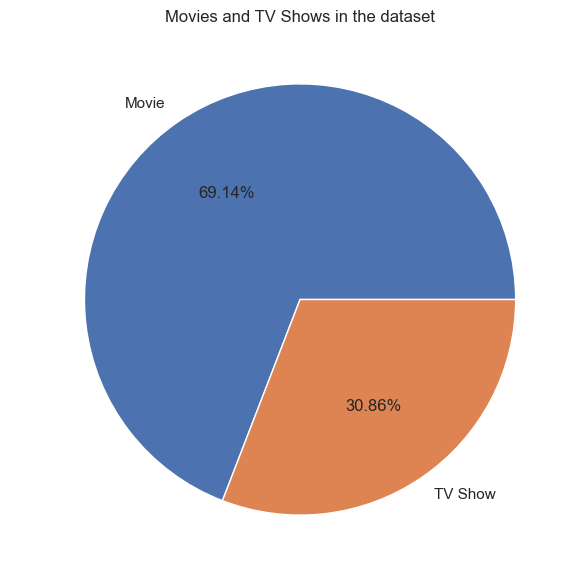

In [340]:
# Number of Movies and TV Shows in the dataset
plt.figure(figsize=(7,7))
df.type.value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.ylabel(' ')
plt.title('Movies and TV Shows in the dataset')

* There are more movies (69.14%) than TV shows (30.86%) in the dataset.

Text(0.5, 1.0, 'Top 10 directors by number of shows directed')

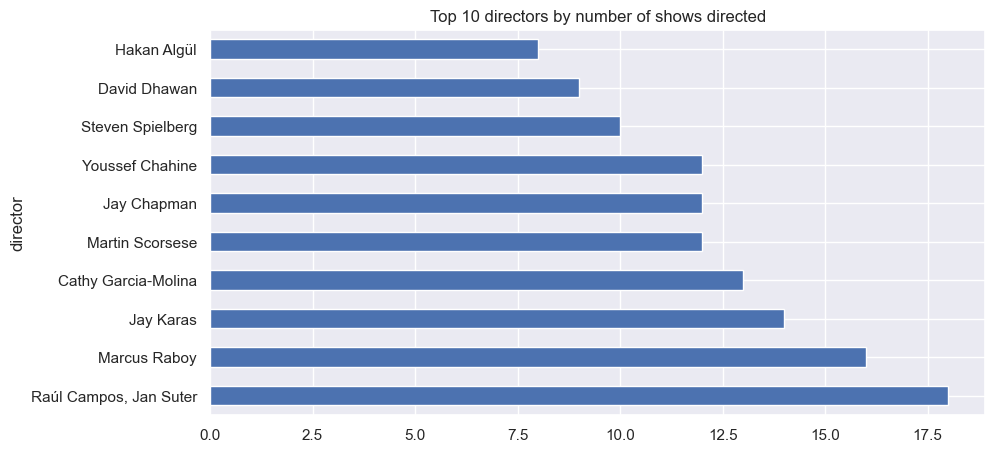

In [341]:
# Top 10 directors in the dataset
plt.figure(figsize=(10,5))
df[~(df['director']=='Unknown')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 directors by number of shows directed')

* Raul Campos and Jan Suter together have directed 18 movies / TV shows, higher than anyone in the dataset.

Text(0.5, 1.0, ' Top 10 countries with the highest number of shows')

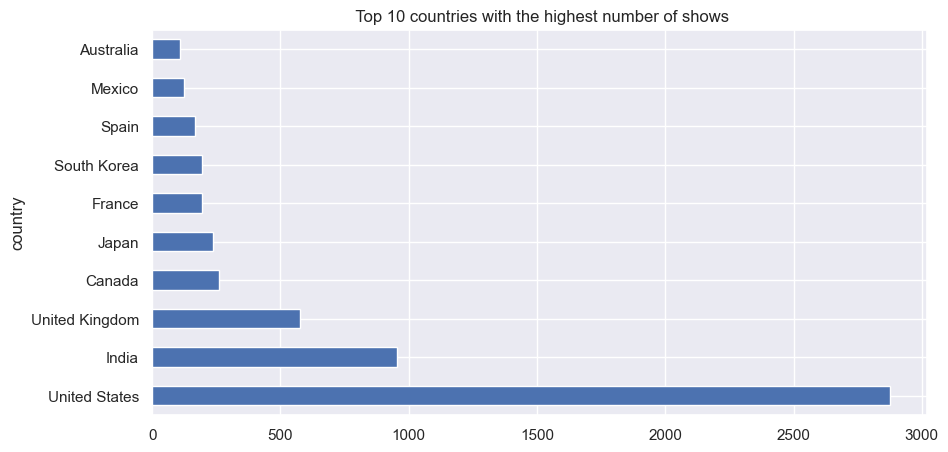

In [342]:
# Top 10 countries with the highest number movies/ TV shows in the dataset
plt.figure(figsize=(10,5))
df[~(df['country']=='Unknown')].country.value_counts().nlargest(10).plot(kind='barh')
plt.title(' Top 10 countries with the highest number of shows')

* The highest number of movies / TV shows were based out of the US, followed by India and UK.

In [343]:
# % share of movies / tv shows by top 3 countries
df.country.value_counts().nlargest(3).sum()/len(df)*100

np.float64(56.69281213835669)

In [344]:
# % share of movies / tv shows by top 10 countries
df.country.value_counts().nlargest(10).sum()/len(df)*100

np.float64(78.32068921177832)

* The top 3 countries together account for about 56% of all movies and TV shows in the dataset.
* This value increase to about 78% for top ten countries.

In [345]:
# Visualizing the year in which the movie / tv show was released
plt.figure(figsize=(10,5))
sns.histplot(df['release_year'])
plt.title('distribution by released year')

Text(0.5, 1.0, 'distribution by released year')

Netflix has greater number of new movies / TV Shows than the old ones.

In [346]:
# Top 10 genres
plt.figure(figsize=(10,5))
df.listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres')

Text(0.5, 1.0, 'Top 10 genres')

In [347]:
# Share of top 3 genres
df.listed_in.value_counts().nlargest(3).sum()/len(df)*100

np.float64(12.536967982512536)

In [348]:
# Share of top 10 genres
df.listed_in.value_counts().nlargest(10).sum()/len(df)*100

np.float64(29.78012086922978)

* The dramas is the most popular genre followed by comedies and documentaries.
* These three genres account for about 41% of all movies and TV shows.
* This value increases to about 82% for top 10 genres.

In [ ]:
# Number of shows added over the years
plt.figure(figsize = (10,5)) 

sns.countplot(df['year_added'])
plt.title('Number of shows added each year')
plt.xlabel('')

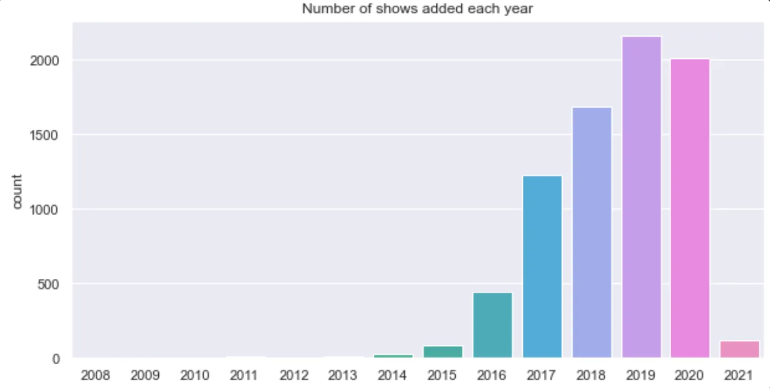

* Netflix continuos to add more shows on its platform over the years.
* There is a decrease in the number of shows added in the year 2020, which might be attributed to the covid-19-induced lockdowns, which halted the creation of shows.
* We have Netflix data only up to 16th January 2021, hence there are less movies added in this year.

Text(0.5, 1.0, 'Number of shows on Netflix for different age groups')

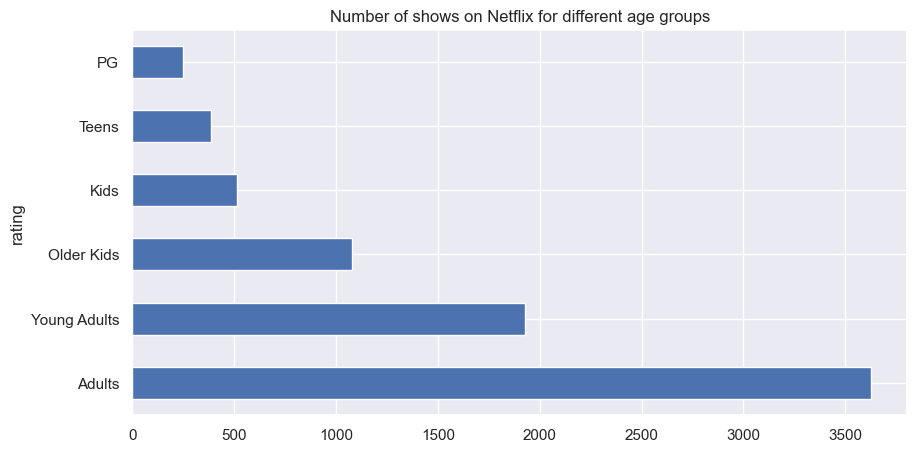

In [351]:
# Number of shows on Netflix for different age groups
plt.figure(figsize=(10,5))
df.rating.value_counts().plot(kind='barh')
plt.title('Number of shows on Netflix for different age groups')

* The majority of the shows on Netflix are catered to the needs of adult and young adult population.

#### **5.2. Bivariate analysis:**

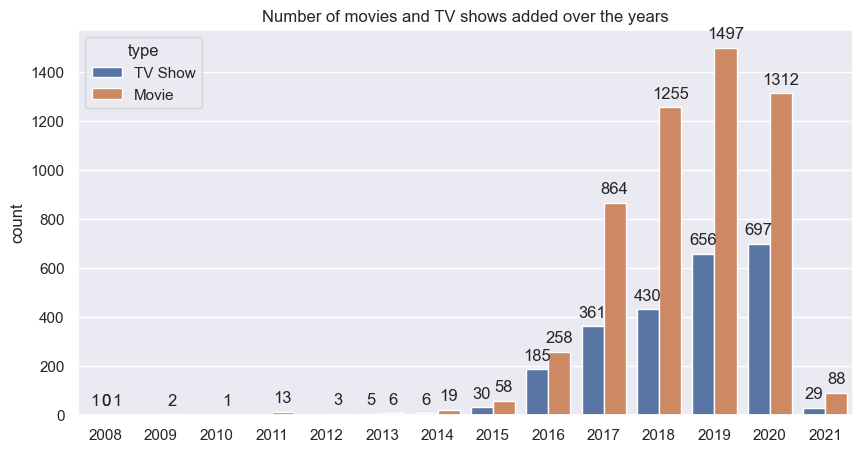

In [352]:
# Number of movies and TV shows added over the years
plt.figure(figsize=(10,5))
p = sns.countplot(x='year_added',data=df, hue='type')
plt.title('Number of movies and TV shows added over the years')
plt.xlabel('')
for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
# Number of shows released each year since 2008
order = range(2008,2022)
plt.figure(figsize=(10,5))
p = sns.countplot(x='release_year',data=df, hue='type',
                  order = order)
plt.title('Number of shows released each year since 2008 that are on Netflix')
plt.xlabel('')
for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

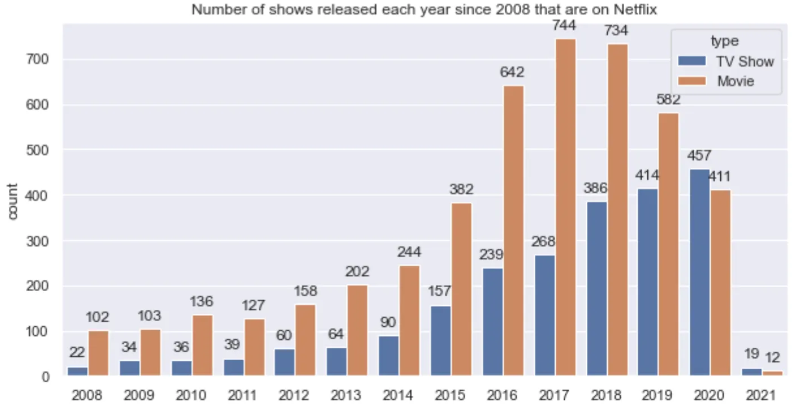

* Over the years, Netflix has consistently focused on adding more shows in its platform.
* Though there was a decrease in the number of movies added in 2020, this pattern did not exist in the number of TV shows added in the same year.
* This might signal that Netflix is increasingly concetrating on introducing more TV series to its platform rather than movies.

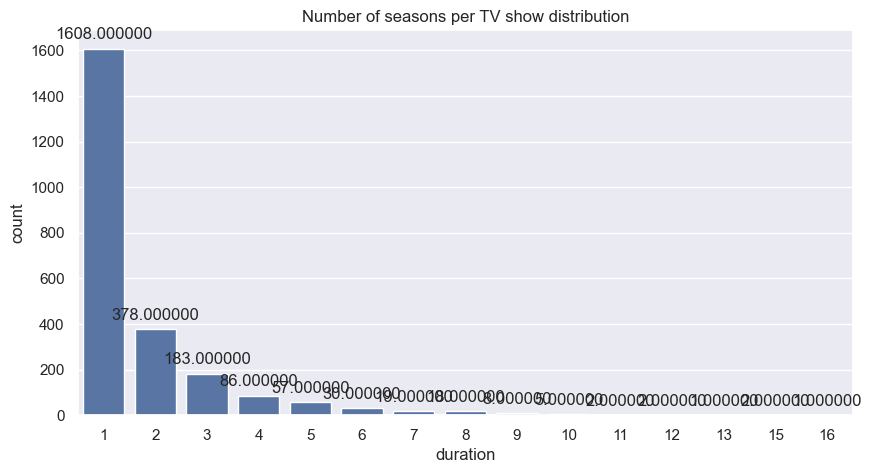

In [354]:
# Seasons in each TV show
plt.figure(figsize=(10,5))
p = sns.countplot(x='duration',
                  data=df[df['type']=='TV Show'])
plt.title('Number of seasons per TV show distribution')

for i in p.patches:
    p.annotate(format(i.get_height(), '0f'),
               (i.get_x() + i.get_width() / 2., i.get_height()),
               ha = 'center', va = 'center', xytext=(0, 10),
               textcoords='offset points')

In [355]:
# % of tv shows with just 1 season
len(df[(df['type']=='TV Show') & (df['duration']==1)]) / len(df[df['type']=='TV Show'])* 100

67.0

* The TV series in the dataset have up to 16 seasons, however the bulk of them only have one. THis might mean that the majority of TV shows has only recently begun, and that further seasons are on the way.
* There are very few TV shows that have more than 8 seasons.

Text(0.5, 1.0, 'Movie duration distribution')

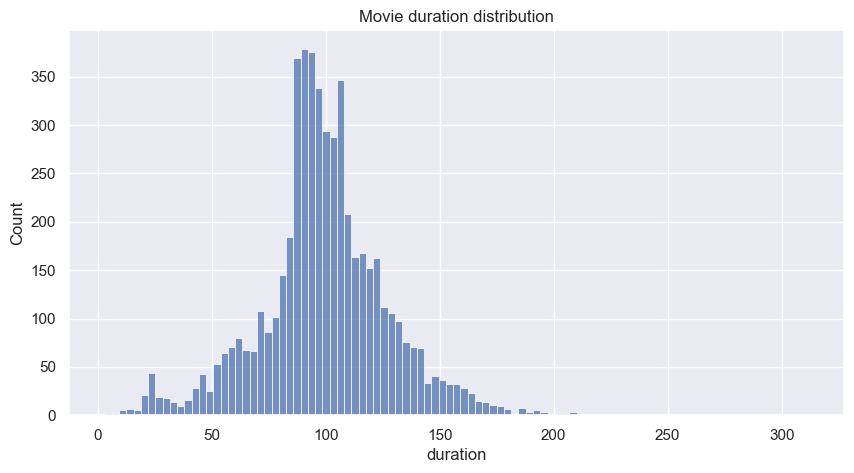

In [356]:
# length of movie analysis
plt.figure(figsize=(10,5))
sns.histplot(x='duration', data=df[df['type']=='Movie'])
plt.title('Movie duration distribution')

In [357]:
# Movie statistics
df[df['type']=='Movie'].duration.describe()

count    5377.000000
mean       99.307978
std        28.530881
min         3.000000
25%        86.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: duration, dtype: float64

* The length of a movie may range from 3 min to 312 minutes, and the distribution is almost normally distributed.

In [358]:
# Average movie length over the years
plt.figure(figsize=(10,5))
df[df['type']=='Movie'].groupby('release_year')['duration'].mean().plot(kind='line')
plt.title('Average movie length over the years')
plt.ylabel('Length of movie in minutes')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

In [359]:
# Movie release year statistics
df[df['type']=='Movie'].release_year.describe()

count    5377.000000
mean     2012.920030
std         9.663282
min      1942.000000
25%      2012.000000
50%      2016.000000
75%      2018.000000
max      2021.000000
Name: release_year, dtype: float64

* Netflix has several movies on its site, including those that were released in way back 1942.
* As per the plot, movies made in the 1940s had a fairly short duration on average.
* On average, movies made in the 1960s have the longest movie length.
* The average length of a movie has been continuously decreasing since the 2000s.

Text(0.5, 1.0, 'Top 10 genres for movies')

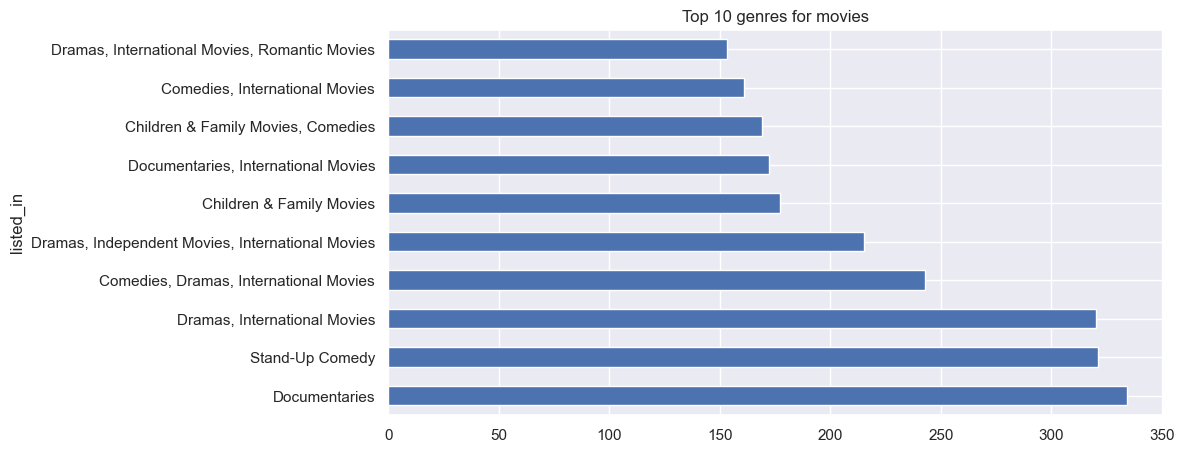

In [360]:
# Top 10 genre for movies
plt.figure(figsize=(10,5))
df[df['type']=='Movie'].listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres for movies')

* Dramas, comedis, and documentaries are the most popular genre for the movies on Netflix.

In [361]:
# Top 10 genre for tv shows
plt.figure(figsize=(10,5))
df[df['type']=='TV Show'].listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres for TV Shows')

Text(0.5, 1.0, 'Top 10 genres for TV Shows')

* International, crime, and kids are the most popular genre for TV shows on Netflix.

Text(0.5, 1.0, 'Top 10 movie directors')

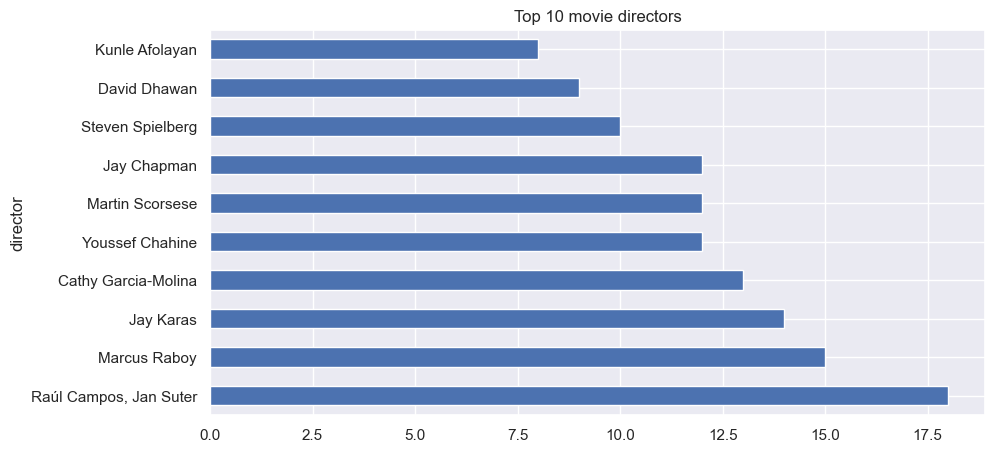

In [362]:
# Top 10 movie directors
plt.figure(figsize=(10,5))
df[~(df['director']=='Unknown') & (df['type']=='Movie')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 movie directors')  

* Raul Campos and Jan Suter have togather directed in 18 movies, higher than anyone yet.
* This is follwoed by Marcus Roboy, Jay Karas, and Cathy Gracia-Molina.

Text(0.5, 1.0, 'Top 10 TV show directors')

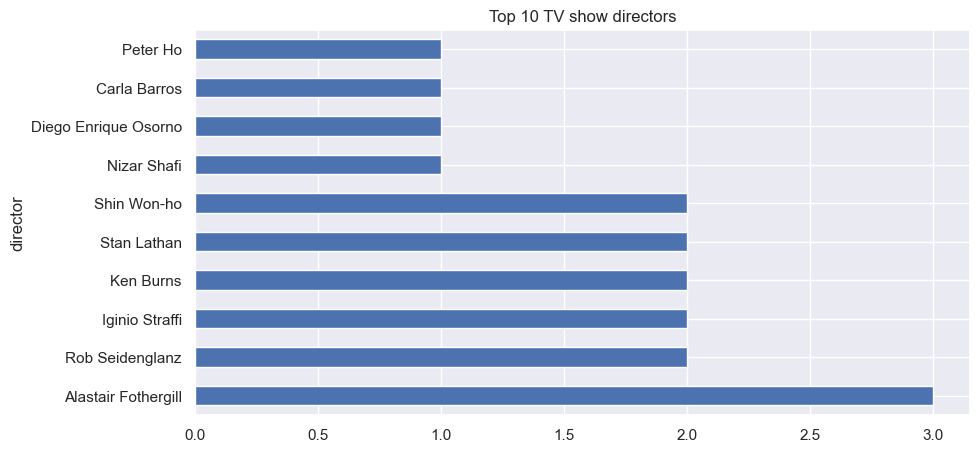

In [363]:
# Top 10 TV show directors
plt.figure(figsize=(10,5))
df[~(df['director']=='Unknown') & (df['type']=='TV Show')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 TV show directors')

* Alastair Fothergill has directed three TV shows, the most of any director.
* Only six directors have directed more than one television show.

In [364]:
# Top actors for movies
plt.figure(figsize=(10,5))
df[~(df['cast']=='Unknown') & (df['type']=='Movie')].cast.value_counts().nlargest(10).plot(kind='barh')
plt.title('Actors whon have appeared in highest number of movies')

Text(0.5, 1.0, 'Actors whon have appeared in highest number of movies')

* Samuel West has appeared in 10 movies, followed by Jeff Dunham with 7 movies.

Text(0.5, 1.0, 'Actors who have appeared in highest number of TV shows')

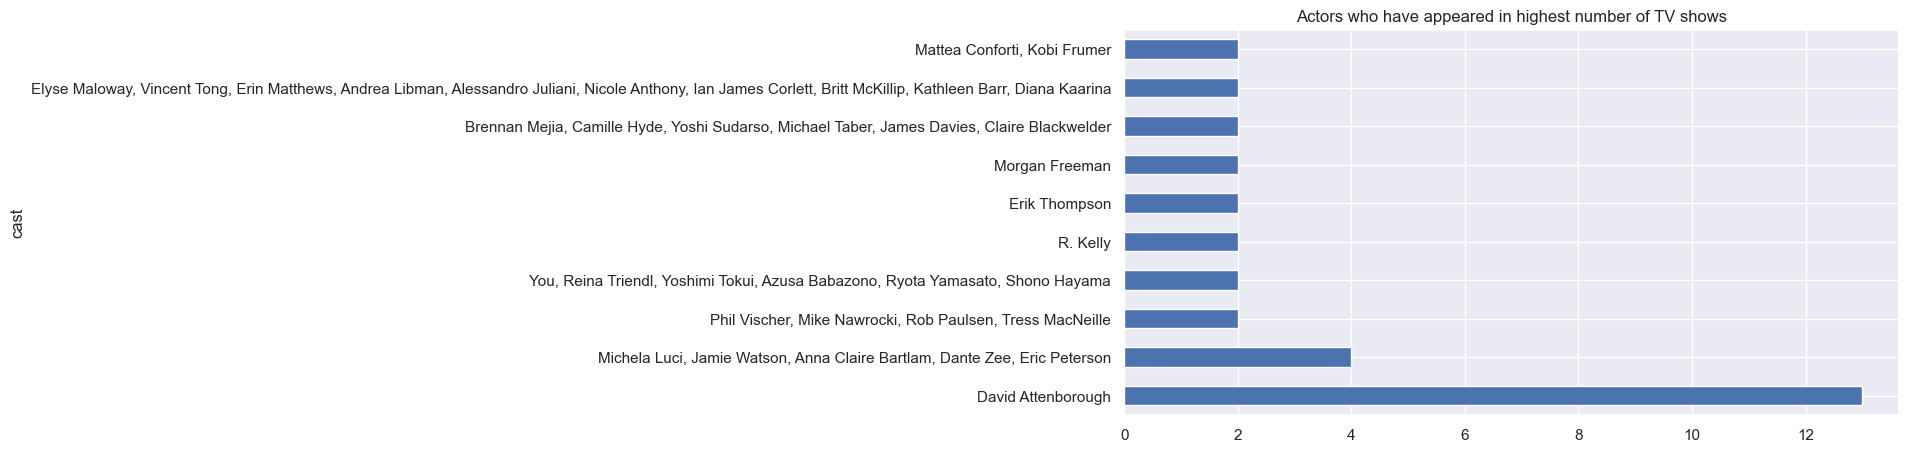

In [365]:
# Top actors for TV shows
plt.figure(figsize=(10,5))
df[~(df['cast']=='Unknown') & (df['type']=='TV Show')].cast.value_counts().nlargest(10).plot(kind='barh')
plt.title('Actors who have appeared in highest number of TV shows')

* David Attenborough has appeared in 13 TV shows, followed by Michela Luci, Jamie Watson, Anna Clarie Bartlam, Dante Zee, Eric Peterson with 4 TV shows.

In [366]:
# Building a worldcloud for the movie descriptions
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.description.values:

    # typecast each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens) + " "


wordcloud = WordCloud(width=700,
                       height=700,
                       background_color='white',
                       stopwords=stopwords,
                       min_font_size=10).generate(comment_words)

# plot the WorldCloud image 
plt.figure(figsize=(10,5), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

### **6. Data preprocessing:**
---

#### **6.1. Modeling Approach:**

1. Select the attributes based on which you want to cluster the shows
2. Text preprocessing: Remove all non-ascii characters, stopwords and punctuation marks, convert all textual data to lowercase.
3. Lemmatization to generate a meaningful word out of corpus of words
4. Tokenization of corpus
5. Word vectorization
6. Dimensionality reduction
7. Use different algorithms to cluster the movies, obtain the optimal number of clusters using different techniques
8. Bulid optimal number of clusters and visualize the contents of each cluster using wordcluds.

We will cluster the shows on Netflix based on the following attributes:
    * Director
    * Cast
    * Country
    * Listed in (genres)
    * Description

In [371]:
# Using the original dataset for clustering since
# it does not require handling missing values
df1 = original_df.copy()

In [372]:
df.fillna('', inplace=True)

In [373]:
# Combining all the clustering attributes into a single column
df1['clustering_attributes'] = (df1['director'] + ' ' + 
                                df1['cast'] + ' ' + 
                                df1['country'] + ' ' + 
                                df1['listed_in'] + ' ' + 
                                df1['description'])

In [374]:
df1['clustering_attributes'][40]

'Muharrem Gülmez Erdem Yener, Ayhan Taş, Emin Olcay, Muharrem Gülmez, Elif Nur Kerkük, Tarık Papuççuoğlu, Suzan Aksoy, Doğa Konakoğlu, Esin Eden, Deniz Özerman Turkey Comedies, International Movies The slacker owner of a public bath house rallies his community to save it when a big developer comes to town to close it down and open a new mall.'

* We have successfully added all the necessary data into a single column.

#### **6.2. Removing non-ASCII charaters:**

In [375]:
# function to remove non-ascii characters

def remove_non_ascii(words):
    """Function to remove non-ASCII characters"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', str(word)).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [376]:
# remove non-ascii characters
df1['clustering_attributes'] = remove_non_ascii(df1['clustering_attributes'])

In [377]:
df1['clustering_attributes'][40]

'Muharrem Gulmez Erdem Yener, Ayhan Tas, Emin Olcay, Muharrem Gulmez, Elif Nur Kerkuk, Tark Papuccuoglu, Suzan Aksoy, Doga Konakoglu, Esin Eden, Deniz Ozerman Turkey Comedies, International Movies The slacker owner of a public bath house rallies his community to save it when a big developer comes to town to close it down and open a new mall.'

* We have lemmatized the corpus.

#### **6.6. Tokenization:**

In [378]:
tokenizer = TweetTokenizer()

In [379]:
df1['clustering_attributes'] = df1['clustering_attributes'].apply(lambda x: tokenizer.tokenize(x))

* The corpus is converted to tokens.

#### **6.7. Vectorization:**

* We can vectorize the corpus using TFIDF vectorizer, where TFIDF stands for - Term Frequency Inverse Document Frequency.

In [380]:
# clustering tokens saved in a variable
clustering_data = df1['clustering_attributes']

In [381]:
# Tokenization
def identity_tokenizer(text):
    return text

# Using TFIDF vectorizer to vectorize the corpus 
# max features = 20000 to prevent system from crashing
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False,max_features = 20000)    
X = tfidf.fit_transform(clustering_data)

In [382]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 175483 stored elements and shape (7789, 20000)>

In [383]:
# shape of X
X.shape

(7789, 20000)

In [384]:
# data type of vector
type(X)

scipy.sparse._csr.csr_matrix

In [385]:
# convert X into array from for clustering
X = X.toarray()

#### **6.8. Dimensioanlity reduction using PCA:**

* We can use PCA (Principal component Analysis) to reduce the dimensioanlity of data.

In [386]:
# Using PCA to reduce dimensionality
pca = PCA(random_state=42)
pca.fit(X)

PCA(random_state=42)

Text(0, 0.5, 'cumulative explained variance')

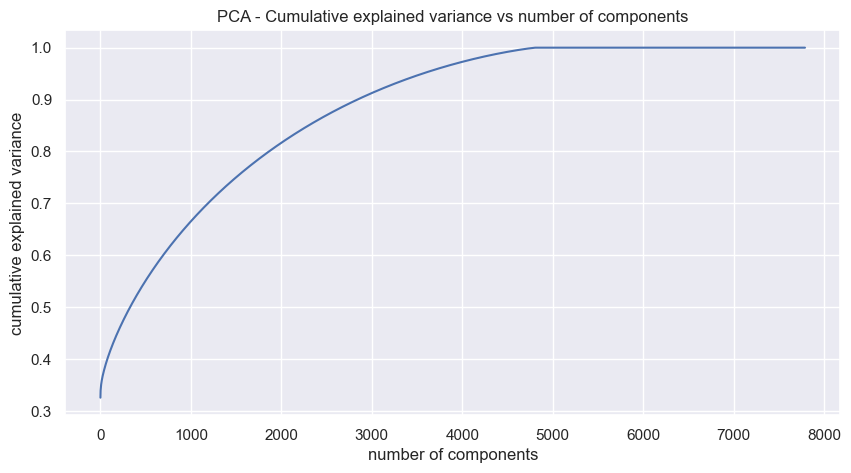

In [387]:
# Explained variance for different number of components
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - Cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

* We find that 100% of the variance is explained by about ~7500 components.
* Also, more than 80% of the variance is explained just by 4000 components.
* Hence to simplfy the model, and reduce dimensionally, we can take the top 4000 components, which will still be able to capture more than 80% of variance.

In [388]:
# reducing the dimensions to 4000 using pca
pca = PCA(n_components=4000, random_state=42)
pca.fit(X)

PCA(n_components=4000, random_state=42)

In [392]:
# transformed features
x_pca = pca.transform(X)

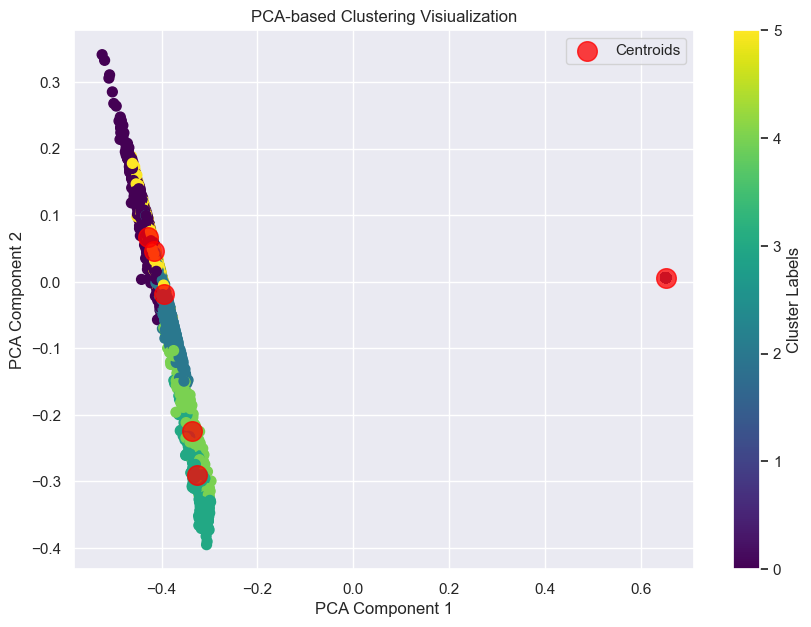

In [395]:
# Kmeans clustering
kmeans = KMeans(n_clusters=6, random_state=0)   # classifying 4 cluster
clusters = kmeans.fit_predict(x_pca)

# visulaization
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=clusters, cmap='viridis', s=50)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, label='Centroids')
plt.title('PCA-based Clustering Visiualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.colorbar(scatter, label='Cluster Labels')
plt.show()

In [393]:
# shape of transformed vectors
x_pca.shape

(7789, 4000)

* We have successfully reduced the dimensionally of data using PCA.

### **7.Cluters implementation:**
---

#### **7.1. K-Means Clustering:**

Building clusters using the K-means clustering algorithm.

Visualizing the elbow curve and Silhouette score to decide on the optimal number of cluster for k-means clustering algorithm.

Text(0, 0.5, 'WCSS')

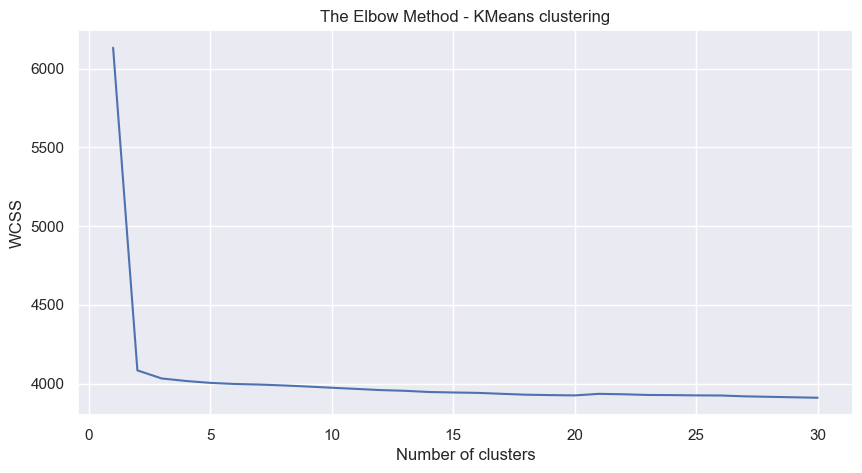

In [397]:
# Elbow method to find the optimal value of k
wcss=[]
for i in range(1,31):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,31)
plt.figure(figsize=(10, 5))
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method - KMeans clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

* The sum of squared distance between each point and the centroid in a cluster(WCSS) decreases with the increase in the number of clusters.

In [399]:
# Plotting Silhouette score for different umber of clusters
range_n_clusters = range(2, 31)
silhouette_avg = []
for number_clusters in range_n_clusters:
    # initialize kmeans
    kmeans = KMeans(n_clusters=number_clusters,
                    init='k-means++',
                    random_state=33)
    kmeans.fit(x_pca)
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg.append(silhouette_score(x_pca, cluster_labels))

plt.figure(figsize=(10,5))
plt.plot(range_n_clusters, silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette analysis For Optimal K - KMeans custering')
plt.show()

* The highest Silhouette score is obtained for 6 clusters.

Building 6 clusters using the K-means clustering algorithm:

In [158]:
# Clustering the data into 19 clusters
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=33)
kmeans.fit(x_pca)

KMeans(n_clusters=6, random_state=33)

In [403]:
# cluster alocation and clustering centroid
clusters = kmeans.labels_
centroid = kmeans.cluster_centers_

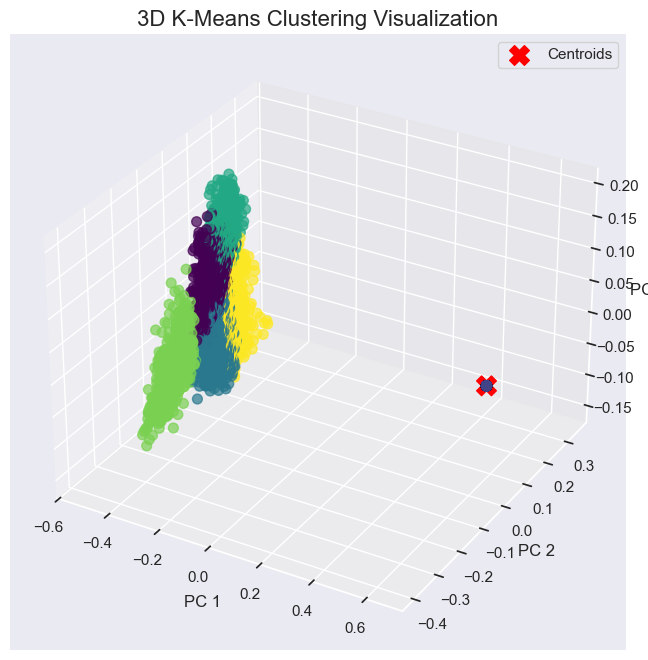

In [412]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming x_pca is the PCA-transformed data
# Fit the KMeans model
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=33)
kmeans.fit(x_pca)

# Extract cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Visualize clusters in 2D
plt.figure(figsize=(10, 7))

# Plot the data points with cluster labels as colors
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7, edgecolors='k')

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')

# Add titles and labels for clarity
plt.title('K-Means Clustering Visualization', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

#==================================================================
#============K-Means clustering visualized in 3D===================
#==================================================================

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=labels, cmap='viridis', s=50, alpha=0.7)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', s=200, marker='X', label='Centroids')
ax.set_title('3D K-Means Clustering Visualization', fontsize=16)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.show()

In [472]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming x_pca is the PCA-transformed data
# Fit the KMeans model
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=33)
kmeans.fit(x_pca)

# Extract cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Visualize clusters in 2D
plt.figure(figsize=(10, 7))

# Plot the data points with cluster labels as colors
plt.scatter(x_pca[:, 1], x_pca[:, 2], c=labels, cmap='viridis', s=50, alpha=0.7, edgecolors='k')

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')

# Add titles and labels for clarity
plt.title('K-Means Clustering Visualization', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()


* Let's compare with n_cluster = 4

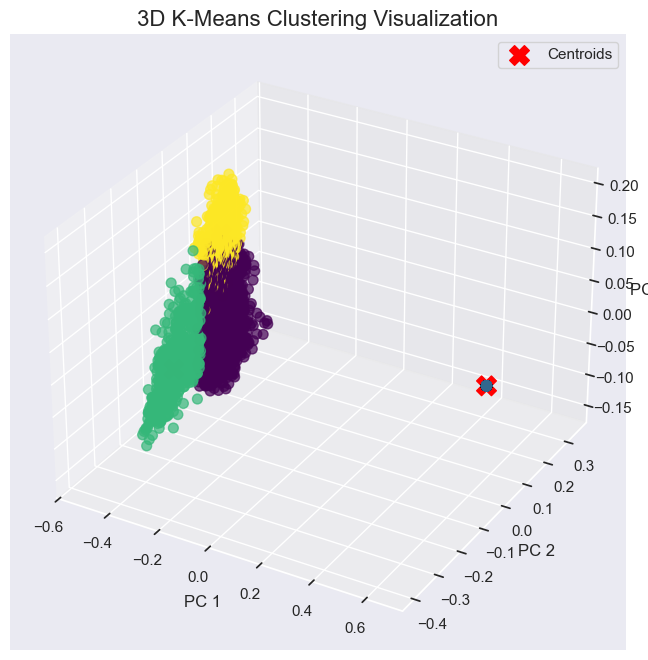

In [413]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming x_pca is the PCA-transformed data
# Fit the KMeans model
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=33)
kmeans.fit(x_pca)

# Extract cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Visualize clusters in 2D
plt.figure(figsize=(10, 7))

# Plot the data points with cluster labels as colors
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7, edgecolors='k')

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')

# Add titles and labels for clarity
plt.title('K-Means Clustering Visualization', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

#==================================================================
#============K-Means clustering visualized in 3D===================
#==================================================================

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=labels, cmap='viridis', s=50, alpha=0.7)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', s=200, marker='X', label='Centroids')
ax.set_title('3D K-Means Clustering Visualization', fontsize=16)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.show()

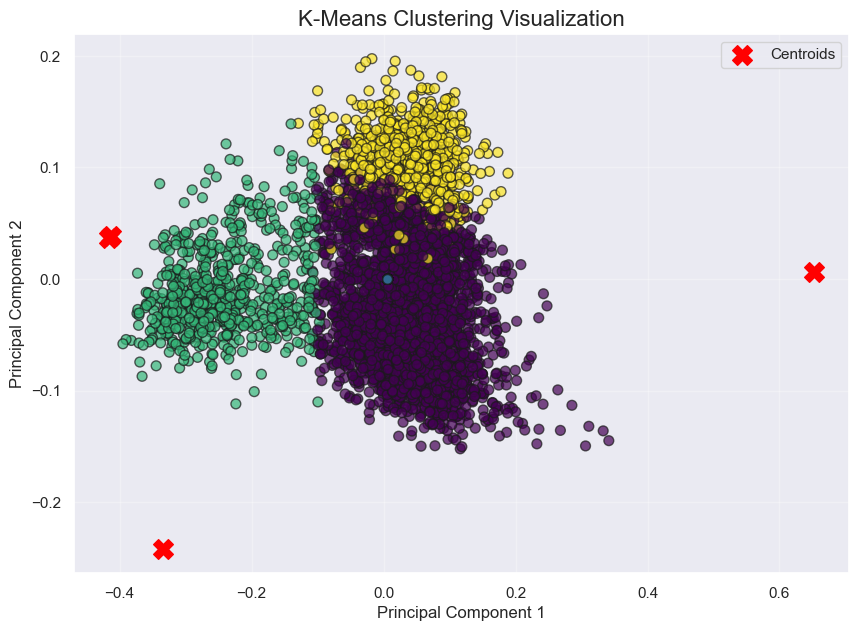

In [473]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming x_pca is the PCA-transformed data
# Fit the KMeans model
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=33)
kmeans.fit(x_pca)

# Extract cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Visualize clusters in 2D
plt.figure(figsize=(10, 7))

# Plot the data points with cluster labels as colors
plt.scatter(x_pca[:, 1], x_pca[:, 2], c=labels, cmap='viridis', s=50, alpha=0.7, edgecolors='k')

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')

# Add titles and labels for clarity
plt.title('K-Means Clustering Visualization', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()


In [406]:
# Evaluation metrics - distortion, Silhouette score
kmeans_distortion = kmeans.inertia_
kmeans_silhouette_score = silhouette_score(x_pca, kmeans.labels_)

print((kmeans_distortion, kmeans_silhouette_score))

(3997.62873313615, np.float64(0.3797627070166119))


In [407]:
# Adding a kmeans cluster number attribute
df1['kmeans_cluster'] = kmeans.labels_

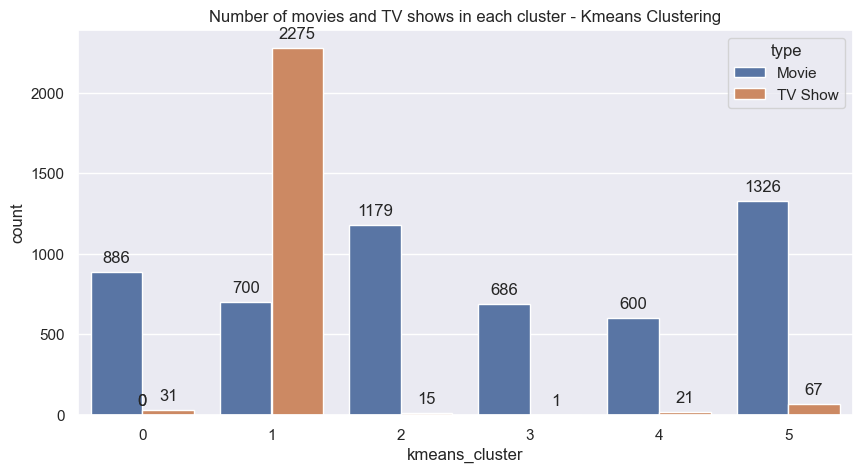

In [419]:
# Number of movies and tv shows in each cluster
plt.figure(figsize=(10,5))
q = sns.countplot(x='kmeans_cluster', data=df1, hue='type')
plt.title('Number of movies and TV shows in each cluster - Kmeans Clustering')

for i in q.patches:
    q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext=(0, 10), textcoords='offset points')

Successfully built 6 clusters using the K-means clustering algorithm.

##### **7.1.1. Building wordclouds for different clusters built**

In [168]:
# Building a wordcloud for the movie descriptions
def kmeans_wordcloud(cluster_num):
  comment_words = ''
  stopwords = set(STOPWORDS)

  # iterate through the csv file
  for val in df1[df1['kmeans_cluster']==cluster_num].description.values:
      
      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()
      
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      
      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 700, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)


  # plot the WordCloud image                      
  plt.figure(figsize = (10,5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

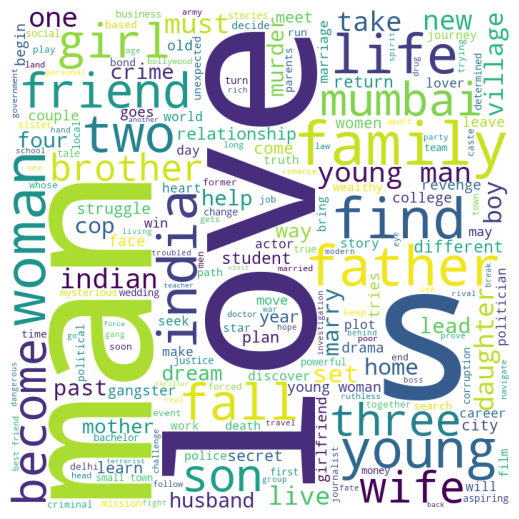

In [170]:
# Wordcloud for cluster 0
kmeans_wordcloud(0)

Keywords observed in cluster 0: life, new, family, friend, save, help, discover, home, teen

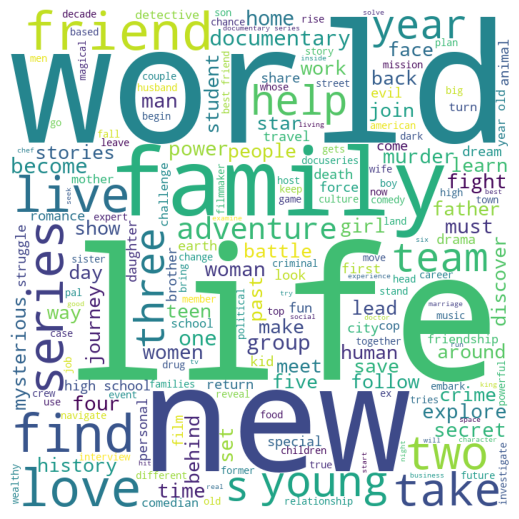

In [171]:
# Wordcloud for cluster 1
kmeans_wordcloud(1)

Keywords observed in cluster 1: life, love, family, father, young, girl, man, woman, friend, daughter

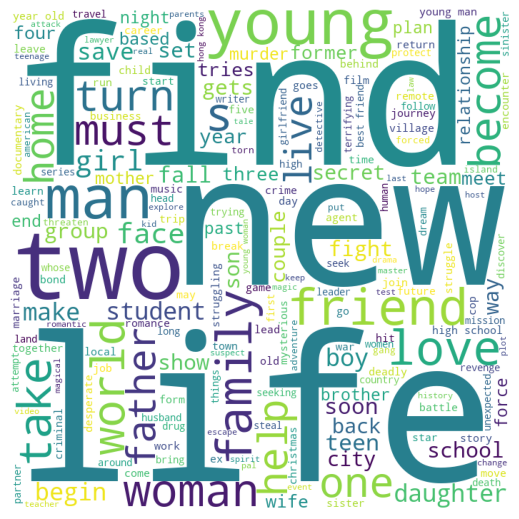

In [172]:
# Wordcloud for cluseter2
kmeans_wordcloud(2)

Keywords observed in cluseter2: young, world, girl, mysterious, humanity, life, student, school, battle, demon, force

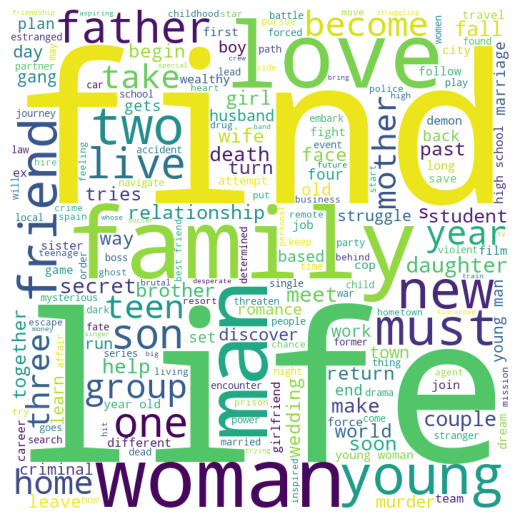

In [173]:
# Wordcloud for cluster 3
kmeans_wordcloud(3)

Keywords observed in cluster 3: love, life, famliy, romance, crime, murder, world, adventure

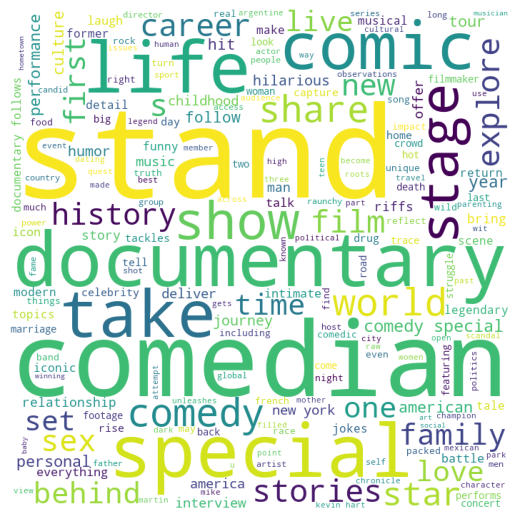

In [169]:
# Wordcloud for cluster 4
kmeans_wordcloud(4)

Keywords observed in cluster 4: comedian, special, stand, comic, stage, sex, joke

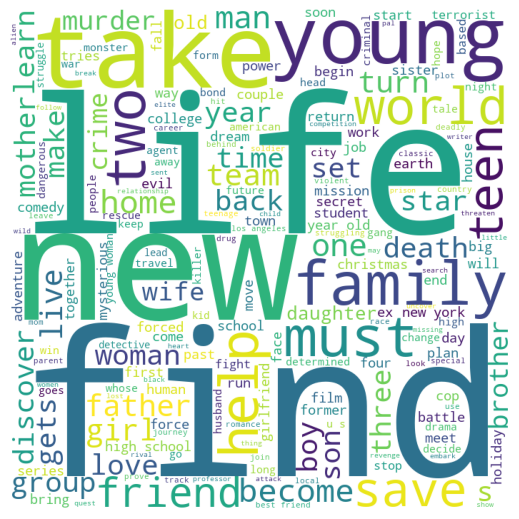

In [174]:
# Wordcloud for cluster 5
kmeans_wordcloud(5)

Keywords observed in cluster 5: documentary, world, life, filmmaker, american, life

#### **7.2. Hierarchical clustering**

Building clusters using the agglomerative (hierarchical) clustering algorithm.

Visualizing the dendrogram to decide on the optimal number of clusters for the agglomerative (hierarchical) clustering algorithm:

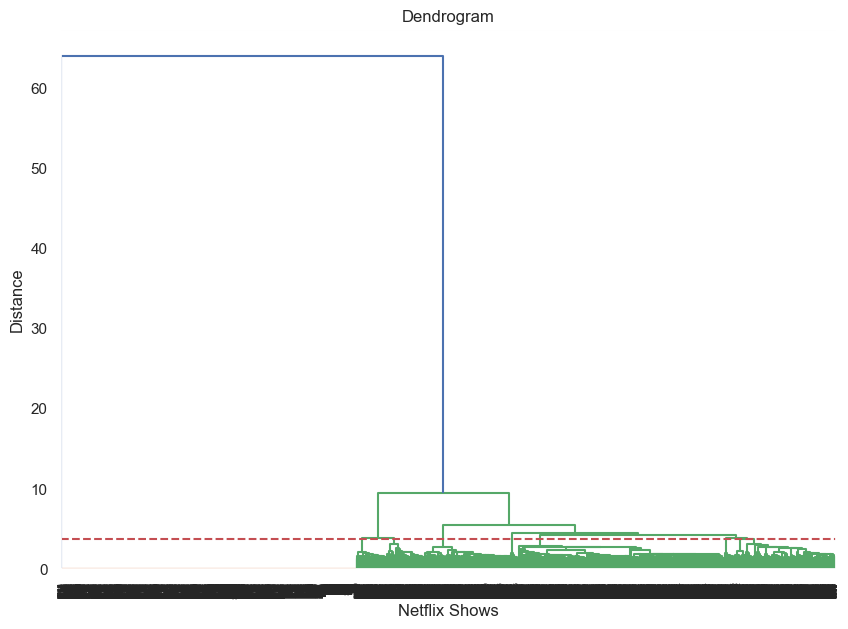

In [433]:
import sys
sys.setrecursionlimit(5000) # regressionerror

# Building a dendogram to decide on the number of clusters
plt.figure(figsize=(10, 7))  
dend = shc.dendrogram(shc.linkage(x_pca, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Netflix Shows')
plt.ylabel('Distance')
plt.axhline(y= 3.8, color='r', linestyle='--')

At a distance of 3.8 units, 12 clusters can be built using the agglomerative clustering algorithm.

Building 12 clusters using the Agglomerative clustering algorithm:

In [429]:
# Fitting hierarchical clustering model
hierarchical = AgglomerativeClustering(n_clusters=12, linkage='ward')  
hierarchical.fit_predict(x_pca)

array([7, 2, 3, ..., 7, 7, 7], shape=(7789,))

In [431]:
# Adding a kmeans cluster number attribute
df1['hierarchical_cluster'] = hierarchical.labels_

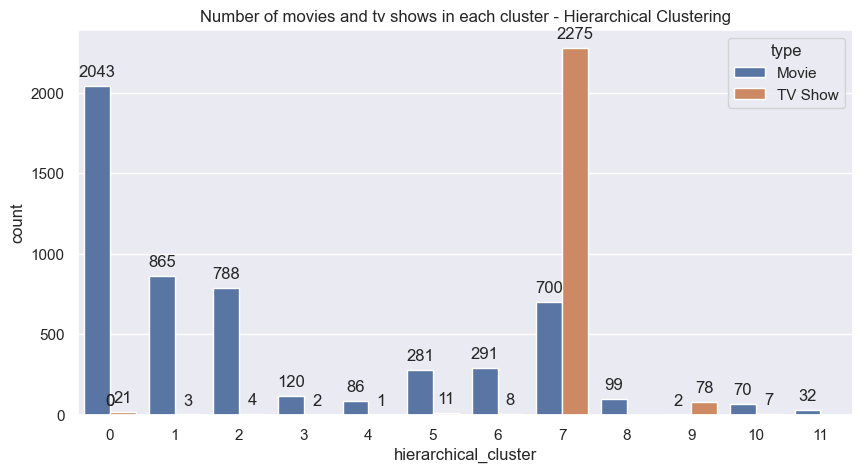

In [434]:
# Number of movies and tv shows in each cluster
plt.figure(figsize=(10,5))
q = sns.countplot(x='hierarchical_cluster',data=df1, hue='type')
plt.title('Number of movies and tv shows in each cluster - Hierarchical Clustering')
for i in q.patches:
  q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Successfully built 12 clusters using the Agglomerative (hierarchical) clustering algorithm.

##### **7.2.1 Building wordclouds for different clusters build:**

In [186]:
# Building a wordcloud for the movie descriptions
def hierarchical_wordcloud(cluster_num):
  comment_words = ''
  stopwords = set(STOPWORDS)

  # iterate through the csv file
  for val in df1[df1['hierarchical_cluster']==cluster_num].description.values:
      
      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()
      
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      
      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 700, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)


  # plot the WordCloud image                      
  plt.figure(figsize = (10,5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

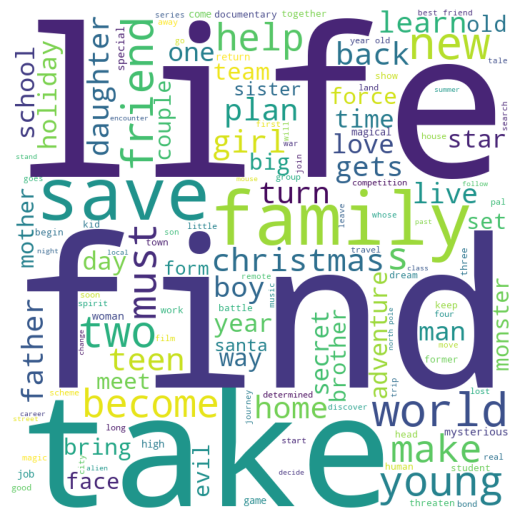

In [187]:
# Worldcloud for cluster 0
hierarchical_wordcloud(0)

Keywords observed in cluster 0: life, new, find, family, save, friend, young, teen, adventure

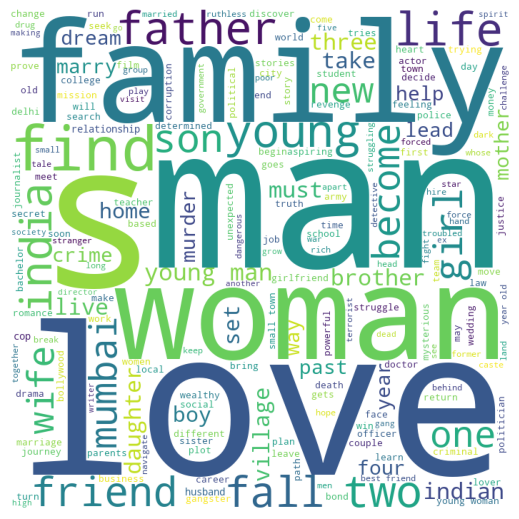

In [188]:
# Worldcloud for cluster 1
hierarchical_wordcloud(1)

Keywords observed in cluster 1: love, family, life, student, romance, school, woman, master, father

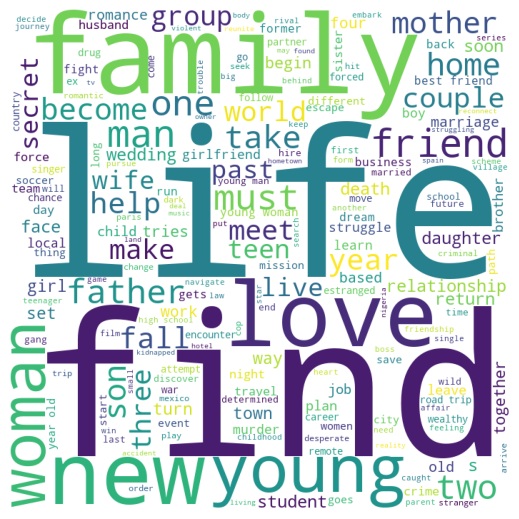

In [189]:
# Worldcloud for cluster 2
hierarchical_wordcloud(2)

Keywords observed in cluster 2: life, new, series, crime, world, murder, history, detective

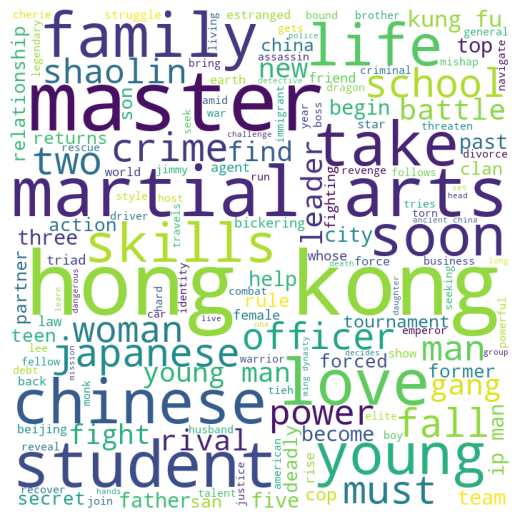

In [190]:
# Wordcloud for cluster 3
hierarchical_wordcloud(3)

Keywords observed in cluster 3: family, life, love, friend, teen, woman, man, young, world, wedding, secret

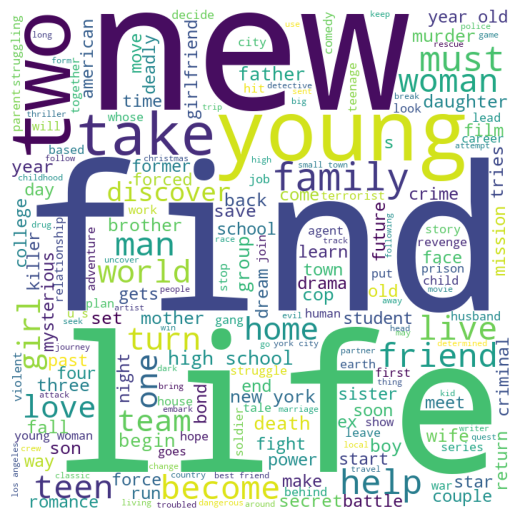

In [191]:
# Wordcloud for cluster 4
hierarchical_wordcloud(4)

Keywords observed in cluster 4: documentary, music, world, team, interview,history, family, career, battle, death

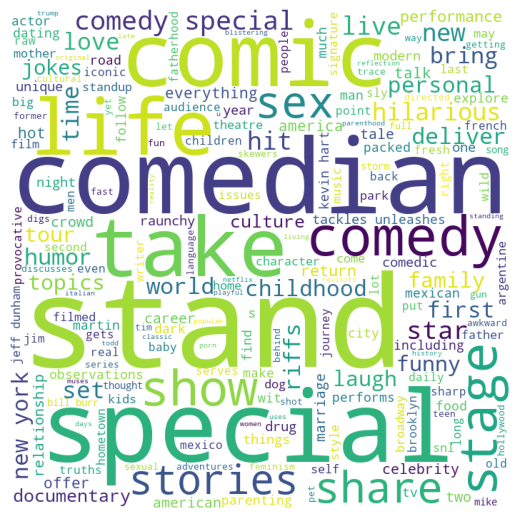

In [192]:
# Wordcloud for cluster 5
hierarchical_wordcloud(5)

Keywords observed in cluster 5: family, life, mexico, young, new, woman, man, secret, spain, death, singer

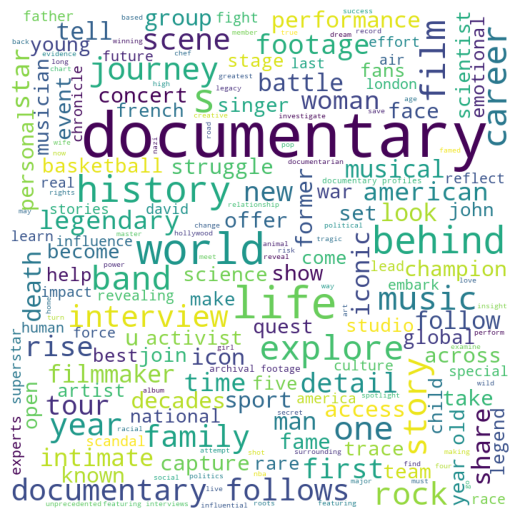

In [193]:
# Wordcloud for cluster 6
hierarchical_wordcloud(6)

Keywords observed in cluster 6: young, life, girl, world, friend, mysterious, demon, student, school, father

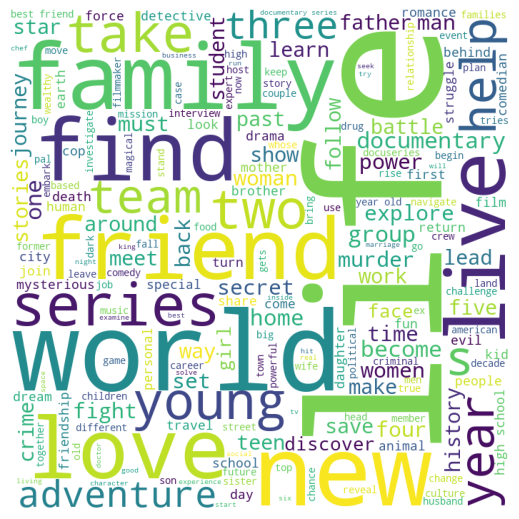

In [194]:
# Wordcloud for cluster 7
hierarchical_wordcloud(7)

Keywords observed in cluster 7: love, life, woman, new, student, family, korea, secret, detective, young

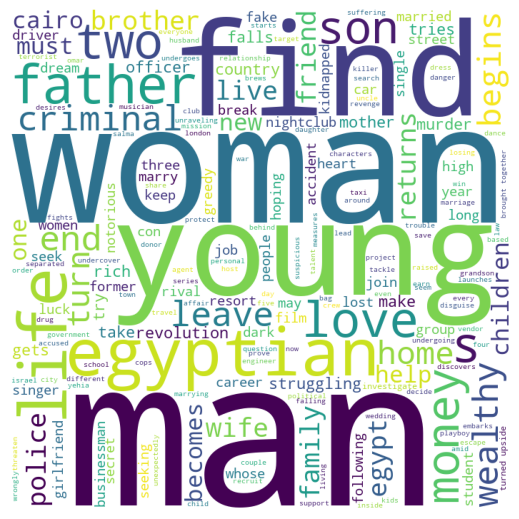

In [195]:
# Wordcloud for cluster 8
hierarchical_wordcloud(8)

Keywords observed in cluster 8: woman, man life, egypt, wealthy, money, young, love, revolution, struggling

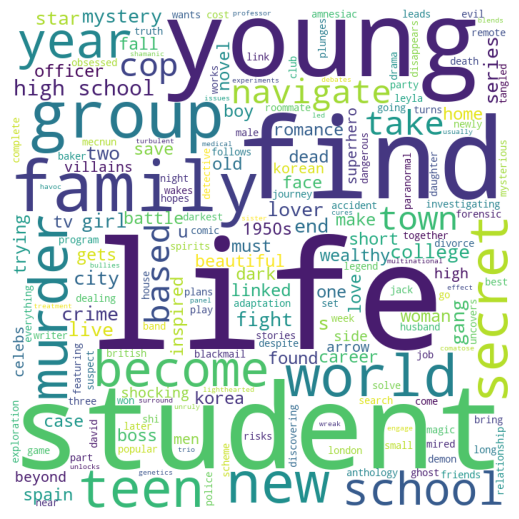

In [196]:
# Wordcloud for cluster 9
hierarchical_wordcloud(9)

Keywords observed in cluster 9: comedian, stand, life, comic, special, show, live, star, stage, hilarious, stories

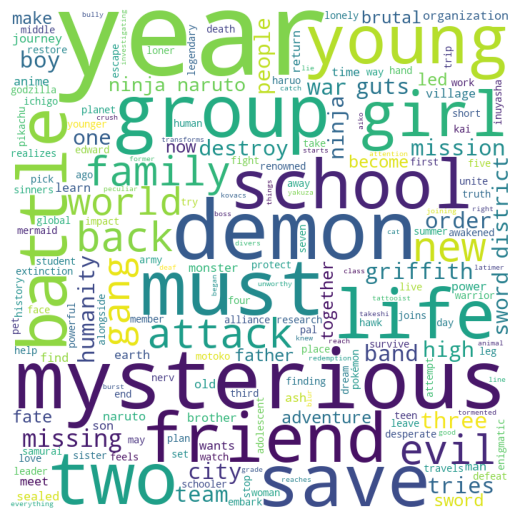

In [197]:
# Wordcloud for cluster 10
hierarchical_wordcloud(10)

Keywords observed in cluster 10: animal, nature, explore, planet, species, survive, natural, life, examine, earth

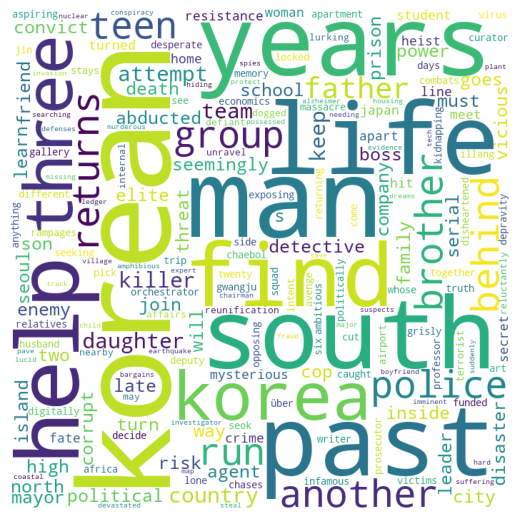

In [198]:
# Wordcloud for cluster 11
hierarchical_wordcloud(11)

Keywords observed in cluster 11: love, man, woman, india, father, friend, girl, mumbai, city, learn, young

### **8. Content based recommender system:**
---

* We can build a simple content based recommender system based on the similarity of the shows.
* If a person has watched a show on Netflix, the recommender system must be able to recommended a list of similar shows that s/he likes.
* To get the similarity score of the shows, we can use cosine similarity product of the two vectors (A and B) is calculated by taking the dot equation. We can simply say that the CS score of two vectors increases as the angle between them decreases.
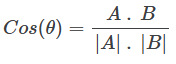

In [199]:
# defining a new df for building a recommender system
recommender_df = df1.copy()

In [200]:
# Chainging the index of the df from show id to show title
recommender_df['show_id'] = recommender_df.index

In [201]:
# converting tokens to string
def convert(lst):
    return ' '.join(lst)

recommender_df['clustering_attributes'] = recommender_df['clustering_attributes'].apply(lambda x: convert(x))

In [202]:
# setting title of movies/TV shows as index
recommender_df.set_index('title', inplace=True)

In [203]:
# Count vectorizer
CV = CountVectorizer()
converted_matrix = CV.fit_transform(recommender_df['clustering_attributes'])

In [205]:
# Cosine similarity 
cosine_similarity = cosine_similarity(converted_matrix)

In [206]:
cosine_similarity.shape

(7787, 7787)

In [207]:
# Developing a function to get 10 recommendations for a show
indices = pd.Series(recommender_df.index)

def recommend_10(title, cosine_sim = cosine_similarity):
  try:
    recommend_content = []   
    idx = indices[indices == title].index[0]
    series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top10 = list(series.iloc[1:11].index)
    # list with the titles of the best 10 matching movies
    for i in top10:
      recommend_content.append(list(recommender_df.index)[i])
    print("If you liked '"+title+"', you may also enjoy:\n")
    return recommend_content

  except:
    return 'Invalid Entry'

In [208]:
# Recommendations for 'A Man Called God'
recommend_10('A Man Called God')

If you liked 'A Man Called God', you may also enjoy:



['3%',
 "Zumbo's Just Desserts",
 'Zulu Man in Japan',
 'Zak Storm',
 'Z4',
 'Z Nation',
 'Yunus Emre',
 'Yummy Mummies',
 'Yu-Gi-Oh! Arc-V',
 'Yu-Gi-Oh!']

In [209]:
# Recommendations for 'Stranger Things'
recommend_10('Stranger Things')

If you liked 'Stranger Things', you may also enjoy:



['3%',
 "Zumbo's Just Desserts",
 'Zulu Man in Japan',
 'Zak Storm',
 'Z4',
 'Z Nation',
 'Yunus Emre',
 'Yummy Mummies',
 'Yu-Gi-Oh! Arc-V',
 'Yu-Gi-Oh!']

In [210]:
# Recommendations for 'Peaky Blinders'
recommend_10('Peaky Blinders')

If you liked 'Peaky Blinders', you may also enjoy:



['3%',
 "Zumbo's Just Desserts",
 'Zulu Man in Japan',
 'Zak Storm',
 'Z4',
 'Z Nation',
 'Yunus Emre',
 'Yummy Mummies',
 'Yu-Gi-Oh! Arc-V',
 'Yu-Gi-Oh!']

In [211]:
# Recommendations for 'Lucifer'
recommend_10('Lucifer')

If you liked 'Lucifer', you may also enjoy:



['3%',
 "Zumbo's Just Desserts",
 'Zulu Man in Japan',
 'Zak Storm',
 'Z4',
 'Z Nation',
 'Yunus Emre',
 'Yummy Mummies',
 'Yu-Gi-Oh! Arc-V',
 'Yu-Gi-Oh!']

In [212]:
# Recommendations for 'XXX'
recommend_10('XXX')

'Invalid Entry'

### **9. Conclusions:**
---